# Imminent ICU Admission Classifier with MLH Notes only using Random Forests

## Imports & Inits

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../../')

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import pickle
import scipy

import pandas as pd
import numpy as np
np.set_printoptions(precision=4)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline

from pathlib import Path

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from scikitplot.metrics import *

from utils.data_utils import set_group_splits
from utils.metrics import BinaryAvgMetrics, get_best_model
from utils.plots import *

In [3]:
from args import args
vars(args)

{'path': PosixPath('../data'),
 'workdir': PosixPath('../data/workdir/rf'),
 'figdir': PosixPath('../data/workdir/figures'),
 'vectordir': PosixPath('../data/workdir/vectordir'),
 'dataset_csv': PosixPath('../data/unstructured_proc.csv'),
 'threshold': 0.16}

## Load Data

In [4]:
seed = 643
notes_df = pd.read_csv(args.dataset_csv, usecols=['hadm_id', 'note', 'imi_adm_label'])
notes_df = notes_df[notes_df['imi_adm_label'] != -1].reset_index(drop=True)
notes_df.shape

(116400, 3)

## Single Model Development

In [5]:
df = set_group_splits(notes_df.copy(), group_col='hadm_id', seed=seed)

train_df = df[df['split'] == 'train'][['note', 'imi_adm_label']]
test_df = df[df['split'] == 'test'][['note', 'imi_adm_label']]

g = train_df.groupby(['imi_adm_label']).size().to_numpy()
print(f"Prevalence of positive class in training set:{(g[1]/g.sum())*100:0.1f}%")
g = test_df.groupby(['imi_adm_label']).size().to_numpy()
print(f"Prevalence of positive class in test set:{(g[1]/g.sum())*100:0.1f}%")

Prevalence of positive class in training set:3.3%
Prevalence of positive class in test set:3.6%


In [7]:
# vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=60_000)
# x_train = vectorizer.fit_transform(train_df['note'])
# x_test = vectorizer.transform(test_df['note'])

# with open(args.vectordir/'bigram_643.pkl', 'wb') as f:
#   pickle.dump(vectorizer, f)
#   pickle.dump(x_train, f)
#   pickle.dump(x_test, f)

with open(args.vectordir/'bigram_643.pkl', 'rb') as f:
  vectorizer = pickle.load(f)
  x_train = pickle.load(f)
  x_test = pickle.load(f)
  
y_train,y_test = train_df['imi_adm_label'], test_df['imi_adm_label']
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((99631, 60000), (16769, 60000), (99631,), (16769,))

In [8]:
clf = RandomForestClassifier(n_estimators=400, min_samples_leaf=3, oob_score=True, class_weight='balanced', n_jobs=-1)

clf.fit(x_train, y_train)

prob = clf.predict_proba(x_test)
pos_prob = prob[:, 1]

labels = ['Delayed', 'Imminent']
label_test = [labels[i] for i in y_test]

Text(0, 0.5, 'Sensitivity')

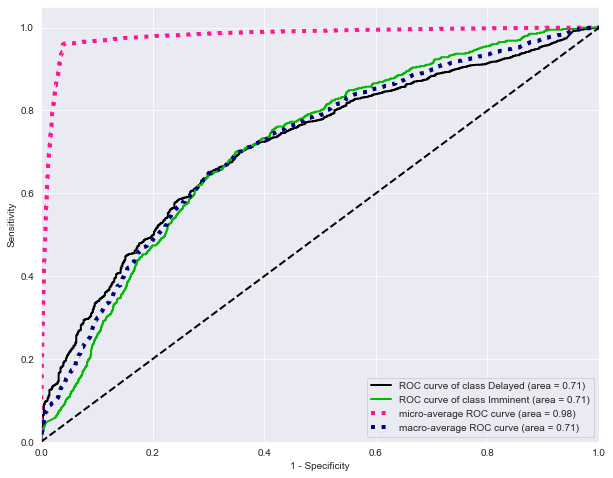

In [9]:
fig, ax = plt.subplots(figsize=(10,8))
plot_roc(label_test, prob, title='', ax=ax)
ax.set_xlabel('1 - Specificity')
ax.set_ylabel('Sensitivity')

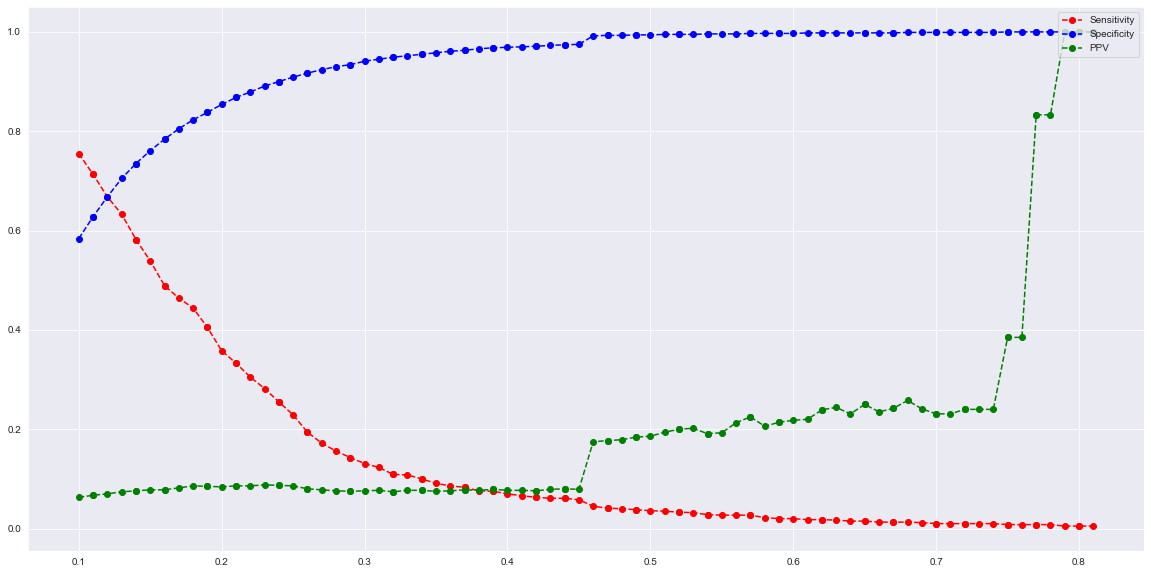

In [10]:
fig, ax = plt.subplots(figsize=(20, 10))
plot_thresh_range(ax, y_test, pos_prob, lower=0.1, upper=0.81, n_vals=100)

In [11]:
fig.savefig(args.figdir/f'rf_unstructured_metrics_vary.pdf', dpi=300, box_inches='tight', pad_inches=0)

Best Youden Threshold = 0.11


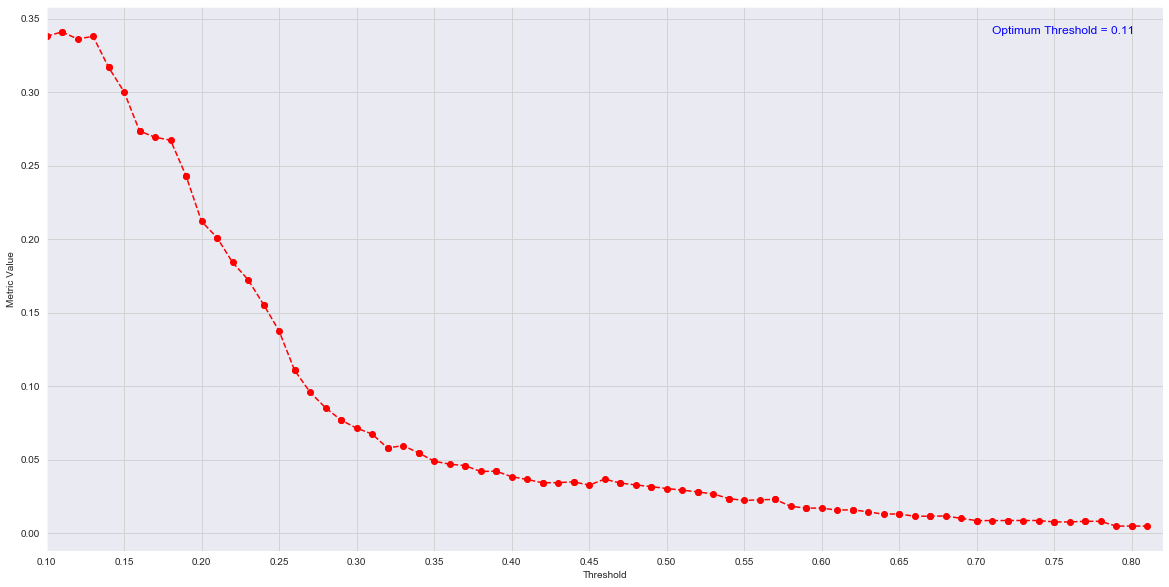

In [12]:
fig, ax = plt.subplots(figsize=(20, 10))
best_threshold = plot_thresh_metric(ax, y_test, pos_prob, lower=0.1, upper=0.81, n_vals=100, show_f1=False)
ax.text(0.71, ax.get_ylim()[1]*0.95, f'Optimum Threshold = {best_threshold[0]}', fontsize=12, color='b')
print(f"Best Youden Threshold = {best_threshold[0]}")

In [17]:
fig.savefig(args.figdir/f'rf_unstructured_youden.pdf', dpi=300, box_inches='tight', pad_inches=0)

In [16]:
threshold = 0.11
pred = (pos_prob > threshold).astype(np.int64)
label_preds = [labels[i] for i in pred]
cm = confusion_matrix(y_test, pred)
tn,fp,fn,tp = cm[0][0],cm[0][1],cm[1][0],cm[1][1]
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
ppv = tp/(tp+fp)
npv = tn/(tn+fn)
f1 = (2*ppv*sensitivity)/(ppv+sensitivity)
auroc = roc_auc_score(y_test, pos_prob)

d = {  
  'sensitivity': np.round(sensitivity, 3),
  'specificity': np.round(specificity, 3),
  'ppv': np.round(ppv, 3),
  'npv': np.round(npv, 3),
  'f1': np.round(f1, 3),
  'auroc': np.round(auroc, 3),
  'threshold': threshold,
}
metrics = pd.DataFrame(d.values(), index=d.keys(), columns=['Value'])
metrics

,Value
sensitivity,0.713
specificity,0.628
ppv,0.067
npv,0.983
f1,0.122
auroc,0.714
threshold,0.110


## Metrics

In [ ]:
with open(args.workdir/f'{args.expt}_preds.pkl', 'rb') as f:
  targs = pickle.load(f)
  probs = pickle.load(f)
  preds = pickle.load(f)

bam = BinaryAvgMetrics(targs, preds, [prob[:, 1] for prob in probs])
bam.get_avg_metrics(defn=True)

In [ ]:
bam.get_avg_metrics(conf=0.95)

In [ ]:
fig, ax = plt.subplots(figsize=(11, 8))
plot_cm(ax, bam.cm_avg, ['Delayed', 'Imminent'])

if save:
  fig.savefig(args.figdir/f'mean_cm.pdf', dpi=300)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_mean_roc(ax, bam.targs, probs)

if save:
  fig.savefig(args.figdir/f'mean_roc.pdf', dpi=300)